<a href="https://www.nvidia.com/dli/"> <img src="https://developer.download.nvidia.com/training/images/DLI%20Header.png" alt="标题" style="width: 400px;"/> </a>

# 简介
自然语言处理 (NLP) 是一套使用计算机分析人类自然语言的技术和算法。NLP 可用于解决各种问题，例如：

* 主题识别——这个文本讨论了哪些主题、人物、公司或地点？
* 情感分析——这个文本传达的对于一个实体或主题的感觉是积极、消极还是中立的？
* 机器翻译——将输入从一种语言转换为另一种语言，例如，从英语到法语
* 文字转语音——将口语输入转换为书面形式
* 理解和解释——哪些信息是对特定问题的回答？

早期的 NLP 系统使用由领域专家人工设计的规则。随着该领域的发展，机器学习的使用使得利用不断增长的数据量的更强大的模型得以应用。今天，我们利用深度学习和 GPU 的强大计算能力来处理越来越复杂的 NLP 任务。

在本次实验中，我们将着重探讨以下三点：
1. 词袋表征及其缺点
2. 使用 Word2Vec 算法计算词嵌入
3. 将预训练词嵌入应用至文本分类问题




# NLP 中数据表征的重要性

数据科学家遇到的最重要的问题之一是如何将数据表征为一个算法。在 NLP 中，输入可采用句子，甚至是整份文档的形式，长度往往不同，数据表征尤为重要。无论输入长度如何，开发一个能够捕获相似主题和/或特定领域的术语和词汇使用的表征都十分重要。我们以 Brian Wildsmith 所著的精彩儿童读物《垫子上的猫》(Cat on the Mat) 中的例子来说明这点。

### 词袋表征
文本的一种常用表征方法是使用*词袋*(BoW) 方法，即我们简单计算出每个词在我们的*语料库*——单个文本或*文档*的集合——中出现的次数，对于集合中的每个文本：

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import HTML

corpus = ['The cat sat on the mat', 'The dog sat on the mat', 'The goat sat on the mat']

vectorizer = CountVectorizer(lowercase=True, analyzer='word', binary=False)
representation = vectorizer.fit_transform(corpus)
representation_df = pd.DataFrame(data = representation.toarray(), columns=sorted(vectorizer.vocabulary_.keys()))
representation_df

,cat,dog,goat,mat,on,sat,the
0,1,0,0,1,1,1,2
1,0,1,0,1,1,1,2
2,0,0,1,1,1,1,2


在此表征中，我们计算一个词在给定输入中出现的频率。这个计数通常被称为*术语频率*。语料库中所有不相同的词的集合被称为语料库的*词汇表*。在词袋表征中，词汇表的大小主要决定文本表征的大小。

类似表征针对相应词语使用二进制值，而不是离散计数。这通常被称为独热编码。它的优点是相对紧凑，因为词汇表中的每个词都用一个位表征。这个表征常用于术语频率与当前应用无关的情况下。

我们使用 *CountVectorizer* 对象，其包含在 Python 的 Scikit-Learn 机器学习工具和算法包中。查看支持 CountVectorizer 的 API [此处](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)。

**练习**：使用 CountVectorizer 对象为每个词创建二进制值。查看[此处](#hint1 "Use the binary= argument to the constructor") 获取提示。

In [2]:
vectorizer = CountVectorizer(lowercase=True, analyzer='word', binary=True)
representation = vectorizer.fit_transform(corpus)
representation_df = pd.DataFrame(data = representation.toarray(), columns=sorted(vectorizer.vocabulary_.keys()))
representation_df

,cat,dog,goat,mat,on,sat,the
0,1,0,0,1,1,1,1
1,0,1,0,1,1,1,1
2,0,0,1,1,1,1,1


在许多情况下，建议去掉“the”、“on”、“in” 等“停用词”，因为这类词频繁出现，却不为文本添加意义，还需要资源来表征。不同语言的停止词不同，部分语言的停止词列表可从此处获取：[https://www.ranks.nl/stopwords](https://www.ranks.nl/stopwords)。去掉停止词可缩减词汇表大小，从而缩减表征的总体大小。

**练习**：使用 CountVectorizer 对象去掉英文停止词。查看[此处](#hint2 "Use the stop_words= argument to the constructor") 获取提示。

In [10]:
vectorizer = CountVectorizer(lowercase=True, analyzer='word', binary=False,
                            stop_words='english')# Use CountVectorizer to remove English stopwords
representation = vectorizer.fit_transform(corpus)
representation_df = pd.DataFrame(data = representation.toarray(), columns=sorted(vectorizer.vocabulary_.keys()))
representation_df

,cat,dog,goat,mat,sat
0,1,0,0,1,1
1,0,1,0,1,1
2,0,0,1,1,1


还有其他的词计数表征方法，例如 [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) 结合一个词在给定语料库中出现的频率，考量其在文档中出现的频率。这增加了出现频率较低的词的权重，弱化了常见的、出现频率较高的词。

#### 与词袋表征相关的问题

BoW 是表征结构数据的一种好方法，常规用于各种 NLP 任务，可快速、高效地实现 70-80% 的准确率。然而，它有三个主要缺点：
1. 词序不变性
2. 缺乏语义泛化
3. 表征虽大，但填充稀疏

我们将依次分析。

##### 词序不变性
在上面的例子中，请注意，BoW 表征无法捕捉到语料库中出现的词的原始顺序。为了深入了解这个概念，考虑使用相同词，但只有顺序不同的句子的表征：


In [5]:
ordering_corpus = ['The cat sat on the mat', 'the mat sat on the cat', 'Mat the cat the sat']
ordering_vectorizer = CountVectorizer(lowercase=True, analyzer='word', binary=True, stop_words='english')
representation = ordering_vectorizer.fit_transform(ordering_corpus)
representation_df = pd.DataFrame(data = representation.toarray(), columns=sorted(ordering_vectorizer.vocabulary_.keys()))
representation_df

,cat,mat,sat
0,1,1,1
1,1,1,1
2,1,1,1


请注意，这些表征完全相同。特别要注意第二个句子，除非在滑稽或讽刺的语境中使用，否则没有任何意义，第三句的英文语法都不正确。虽然词序不变的表征通常对于简单的任务来说已经足够，但在许多情况下，为了获得更高的准确性，词序需包含在内。

注意：运行下面的单元后，请确保未更改*矢量*变量的内容

##### 缺乏语义泛化
查看上面的句子的原始语料库，显然我们可以使用以下方式对其进行表征：

“The X sat on the mat”

其中“X”是一种动物：cat（猫）、dog（狗）或 goat（山羊）。它们在 BoW 中如何表征？

In [6]:
vectorizer.vocabulary_

{'cat': 0, 'dog': 1, 'goat': 2, 'mat': 3, 'sat': 4}

“cat”是第一个特征（出现在独热编码向量的位置 0），“dog”是第二个特征（出现在独热编码向量的位置 1），以此类推。在这种情况下，特征似乎按字母顺序排序。我们可以通过添加字母排序在“cat”之前的另一种动物来验证：

In [7]:
feature_corpus = ['The cat sat on the mat', 'The dog sat on the mat', 'The bird sat on the mat']
feature_vectorizer = CountVectorizer(lowercase=True, analyzer='word', binary=True, stop_words='english')
representation = feature_vectorizer.fit_transform(feature_corpus)
representation_df = pd.DataFrame(data = representation.toarray(), columns=sorted(feature_vectorizer.vocabulary_.keys()))
representation_df

,bird,cat,dog,mat,sat
0,0,1,0,1,1
1,0,0,1,1,1
2,1,0,0,1,1


现在 bird（鸟）是第一个特征，cat（猫）是第二特征，dog（狗）是第三个特征。

在书中，有许多动物坐在垫子上，cat、dog、goat、elephant（大象）。这意味着只有动物能坐在垫子上，而其他对象不能。现在，让我们尝试构建一个简单的分类模型来决定“X on the mat”是否被允许，换句话说，这是一个文本分类问题。

In [19]:
training_corpus = ['The cat sat on the mat', 'The dog sat on the mat', 'The goat sat on the mat', 'The elephant sat on the mat', 
          'The plane sat on the mat', 'The apple sat on the mat', 'The pen sat on the mat', 'The notebook sat on the mat']

allowed = [1,1,1,1,   # Objects that are allowed on the mat
           0,0,0,0]   # Objects that are not allowed on the mat

# Make sure that words we'll use in the test set are considered
# 由于后面测试集中，会出现这样两个单词，此处需要考虑进去，但是最后两行样本并不参与训练
for other_object in ['keyboard', 'bird']:
    training_corpus.append(other_object)   
    
vectorizer = CountVectorizer(lowercase=True, analyzer='word', binary=True, stop_words='english')
representation = vectorizer.fit_transform(training_corpus)
representation_df = pd.DataFrame(data = representation.toarray(), columns=sorted(vectorizer.vocabulary_.keys()))
representation_df

,apple,bird,cat,dog,elephant,goat,keyboard,mat,notebook,pen,plane,sat
0,0,0,1,0,0,0,0,1,0,0,0,1
1,0,0,0,1,0,0,0,1,0,0,0,1
2,0,0,0,0,0,1,0,1,0,0,0,1
3,0,0,0,0,1,0,0,1,0,0,0,1
4,0,0,0,0,0,0,0,1,0,0,1,1
5,1,0,0,0,0,0,0,1,0,0,0,1
6,0,0,0,0,0,0,0,1,0,1,0,1
7,0,0,0,0,0,0,0,1,1,0,0,1
8,0,0,0,0,0,0,1,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0,0,0,0


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logistic = LogisticRegression()
y = allowed
X = representation_df[:len(y)]

logistic.fit(X,y) # Only train on the first 8 sentences
print("Training accuracy score is:  {} %".format(accuracy_score(logistic.predict(X), y)*100.0))

Training accuracy score is:  100.0 %


我们看到，简单的[逻辑回归](https://en.wikipedia.org/wiki/Logistic_regression)模型就能够完美地学习我们的训练数据——允许动物在垫子上，其他对象不行。现在，让我们看看我们的模型能否“泛化”到其他动物和对象：

**练习**：将测试语料库中的句子转换成 BoW 表征。查看[此处](#hint3 "X_test = vectorizer.transform(test_corpus)") 获取答案。

In [21]:
test_corpus = ['The keyboard sat on the mat', 'The bird sat on the mat']
representation_test = vectorizer.transform(test_corpus)
representation_df_test = pd.DataFrame(data = representation_test.toarray(), columns=sorted(vectorizer.vocabulary_.keys()))
representation_df_test


,apple,bird,cat,dog,elephant,goat,keyboard,mat,notebook,pen,plane,sat
0,0,0,0,0,0,0,1,1,0,0,0,1
1,0,1,0,0,0,0,0,1,0,0,0,1


In [22]:
X_test = representation_df_test[:2] # Generate the BoW representation for the test corpus
y_test = [0,1]
print("Expected Results for (keyboard, bird):  {}".format(y_test))
print("Actual   Results for (keyboard, bird):  {}".format(logistic.predict(X_test)))


Expected Results for (keyboard, bird):  [0, 1]
Actual   Results for (keyboard, bird):  [0 0]


我们看到这个简单模型无法捕捉到垫子上允许的动物的泛化。也许一个更强大的模型能够做到这一点。然而，如有可能，理想情况下我们希望将“动物”这个概念（语义概念）直接捕获至输入表征。换句话说，我们想要一个“更明智”的表征，不管使用什么算法。

##### 稀疏性
在 BoW 表征中，每个词是一个特征。因此，对于大型语料库，这意味着单个句子的独热编码向量可以很长。例如，一个包含 1000 个词的词汇表，每个句子由 10 个词组成，则单个输入向量将是 1000 x 10
= 10000 个参数。一个大型语料库可轻松包含更多个词，一个句子可轻松由 30 或 40 个词组成。大型词汇表及其带来的计算复杂性问题有时被称为“维度的诅咒”

此外，一个句子通常只包含词汇表中所有可能词的一小部分。这意味着我们输入的绝大部分数值是 0。这就是所谓的稀疏表征，因为该表征只是稀疏地填充了数据。这将导致有大量的参数需要大量的数据进行训练，并且有过拟合的风险。我们可以只使用词汇表中出现较多的头 k 个单词（由于[自然语言中单词的分布](https://en.wikipedia.org/wiki/Zipf's_law)倾向于只有为数不多的单词出现很频繁），但这也只是权宜之计，并没有直接解决这个问题。

# 分布式表征，即，词嵌入


我们已经看到影响 BoW 表征的一些问题，那么深度学习如何提供帮助？在这部分中，我们讨论如何使用基于神经网络的技术来创建更好的表征。

### 一些理论语言学方面的帮助

为了更好地理解词嵌入，我们看一下首先在语言学语境（特别是统计语义学）中形成的[分布假设](https://en.wikipedia.org/wiki/Distributional_semantics#Distributional_hypothesis)：

> 一个词的特征由它周围的词所决定

> （Firth，1957）

简单地说，分布假设表明，在相似的*句法*语境中出现的词往往具有相似的*语义*含义。换句话说：前后词相同的词具有相似的含义。以上面的例子为例，将每个句子中的动物指定为 X：

The cat sat on the mat

The dog sat on the mat

The elephant sat on the mat

在所有这些例子中，X 前面都有“The”这个单词，后面都跟着“sat on”。更具体地说，X 的前面是“`<PAD>` The”这样一个序列，其中 `<PAD>` 是一个填充值，用于指示句子开头或结尾。这种 2 个单词的“上下文”，两个“词”可在目标词的任何一边捕获。事实上根据定义，所有这些“X”有一些共同之处——它们都是动物。让我们将上面的例子与下面的例子进行比较：

The quickly sat on the mat

显然，由于这个句子在语法上有问题，*quickly*（快速）不会如同动物一样出现于同样的语境。
那么语法正确的句子呢？

The monitor sat on the mat

虽然 X 位置上的名词符合语法，但它没有意义，不太可能用于日常用语。通过应用分布假设，我们基于现有文本，可以假设*quickly*和*monitor*（监视器）在语义上与动物没有相似之处。



### 计算词嵌入

从数学角度来看，嵌入是一种[降维](https://en.wikipedia.org/wiki/Dimensionality_reduction)技术。在 BoW 表征中，每个不同的词是一个维度，总共有 $|V|$  个维度（$V$ 是语料库中所有词的集合）。而嵌入则是低维的，通常在 50 到 300 维之间。嵌入也是稠密向量，通常每一个维度都有一个值。每个维度本质上是一个*潜在因子*，它编码一些关于特定词的信息。因此，嵌入也被称为*分布式表征*。

嵌入具有一个特别有趣的特性：当在一个大型语料库中训练时，这些潜在因子倾向于从语料库的领域中编码语义！换句话说，模型学习特定于该领域的概念和想法。最著名的例子可能来自于 Mikolov 等人在 2013 年发表的重要[论文](https://arxiv.org/pdf/1301.3781.pdf)：

向量（“国王”）- 向量（“男人”）+ 向量（“女人”）~= 向量（“女王”）

也就是说，当从“国王”的嵌入中减去“男人”的嵌入，接着加入“女人”的嵌入（请记住，嵌入只是向量），最接近结果的嵌入是“女王”这个词。Mikolov 在论文中还提供了其他例子。

刚刚讨论的论文介绍了一种用于计算词嵌入的算法——Word2Vec 算法。本实验中，我们将使用这个算法来计算一个小语料库的词嵌入。具体来说，我们使用该算法的 *Skip-Gram* 变体（论文还描述了一种名为 *连续词袋* (CBOW) 的变体——见下文）。


### Word2Vec Skip-Gram

![](images/skip-gram.png)
Skip-Gram 架构，来源：Mikolov 等


Skipgram 算法的原理是，选择成对的目标词和上下文词，并训练一个模型来识别上下文词是否出现在目标词的上下文窗口中。例如，给定句子“the cat sat on the mat”，目标词是“sat”（坐），上下文窗口的大小为 1，则（目标，上下文）词对为：
* （sat，cat）
* （sat，on）

如果上下文窗口大小为 2，将增加另外一对：
* （sat，the）（注意，“the”在“sat”前后的 2 个词的前面都有出现）

我们首先使用两个输入（即目标词和上下文词）创建一个模型。然后，我们添加一个“嵌入层”。该层是一个大小为 $|V|\times d$ 的矩阵，其中 $V$ 如上文所定义，$d$ 作为嵌入维度（超参数）。本质上，嵌入层充当一个查找表，其中（独热编码）目标词和上下文词各从矩阵中选择一行（即向量）。该行就是词嵌入，我们的算法将会学习它。

接下来，使用点积算子来计算两个向量之间的相似度分数。正如上文所解释的，相似语境中的词往往在语义上相似——因此我们希望我们的模型能够习得，每个（目标，上下文）词对都应具有高的相似度分数。

最后，我们使用一种名为 *负采样* 的技术。在负采样中，我们不仅从一个给定句子中选择（目标，上下文）词对，我们还选择该句中 *没有* 出现的词对，即（目标词，非（上下文词））。对于这类词对，我们希望其相似度分数较低。例如，对于同一个句子：

* （cat，sat）——正采样
* （cat，dog）——负采样

因此，我们的输入数据集由（目标，上下文）词对以及标签 0 或 1 组成，数值取决于该词对是正采样还是负采样。请注意，虽然我们有标签，但实际上这是一个“非监督式”问题，因为我们直接从文本中生成标签。因此，可在大量文本上运行这个算法，无需人工干预。然后，该算法会产生特定于语料库的嵌入。

对于这个实验，我们通过添加更多动物，更多动作，甚至家具名词来扩展我们的语料库。回想一下，每个类别的词在语义上是相似的，因为它们出现在相同的语境中。

In [25]:
import itertools

animals = ['cat','dog','goat','elephant','eagle','zebra','rhino', 'hippo']
actions = ['sat','stood','jumped','slept']
furniture = ['mat','rug','sofa','bed']

# Generate all combinations of animal, action and furniture
# 注意，最后+2是因为多了一个the和一个on词汇
animal_corpus = ['The {} {} on the {}'.format(x[0], x[1], x[2]) for x in itertools.product(animals, actions, furniture)]
vocabulary_size = len(animals) + len(actions) + len(furniture) + 2

print("There are {} sentences in the corpus, with a vocabulary of {} words".format(len(animal_corpus), vocabulary_size))

There are 128 sentences in the corpus, with a vocabulary of 18 words


一旦我们有了语料库，我们就使用 Keras 库（Tensorflow 做后端）预处理数据和构建模型。第一步是将每个句子转换成数字序列，其中每个词都有用于独热编码的惟一索引。虽然这种结构与词袋实验中的非常相似，但表征只用于训练嵌入，而 *不* 用于任何其他下游 NLP 任务。

Tokenizer 对象将句子拆分成词，小写后去掉标点符号等所有特殊字符。然后，它为每个词分配一个唯一索引（如上文所述）。接下来，Skipgram 函数创建（目标，上下文）词对。我们将其配置为使用负采样，并使上下文窗口大小成为超参数。有趣的是，请注意，我们在这里不会去掉停止词。

Skip-Gram在训练过程中，是通过一个单词预测周围的词，但是第一个词前面和最后一个词后面是没有单词的，需要增加一个空的单词，比如在英文词汇中是增加一个pad单词，所以在原有词汇表中就会增加一个用于填充的词汇pad，所以vocabulary_size加上1.

In [26]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import skipgrams
import numpy as np

# Hyper-parameters

EMBEDDING_SIZE = 7  # Small corpus, so we're using a small dimension
WINDOW_SIZE = 4     # Empirically found to work well

# Convert text to numerical sequences

tokenizer = Tokenizer(num_words=vocabulary_size+1, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~ ', lower=True, split=' ',)
tokenizer.fit_on_texts(animal_corpus)
sequences = tokenizer.texts_to_sequences(animal_corpus)

# Generate (target, context) pairs with negative sampling

pairs = []
labels = []

for this_sequence in sequences:
    c, l = skipgrams(this_sequence, vocabulary_size+1, window_size=WINDOW_SIZE, negative_samples=1, shuffle=True)
    for i in range(len(c)):
        pairs.append(c[i])
        labels.append(l[i])
pairs = np.array(pairs)
labels = np.array(labels)
    
print("There are {} (context,target) pairs in the dataset".format(len(pairs)))

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


There are 7168 (context,target) pairs in the dataset


我们现在构建并训练模型。

**练习**：在下面的代码中添加嵌入层。查看[此处](#hint4 "Embedding(vocabulary_size+1, EMBEDDING_SIZE, input_length=1, name='embedding_layer") 获取答案。

**练习**：在下面的代码中添加点积层。查看[此处](#hint5 "Dot(axes=1)([target_embedding, context_embedding])") 获取答案。

In [28]:
from keras.layers import Embedding, Input, Dense, Reshape
from keras.layers.merge import Dot
from keras.models import Model
from keras.optimizers import RMSprop



target_word = Input((1,))
context_word = Input((1,))

# An embedding layer is just a lookup table - a matrix of size vocabulary_size x EMBEDDING_SIZE
# We select input_length rows from this matrix

#Add embedding layer nambed 'embedding_layer'.  Remember to add 1 to the vocabulary size!
embedding_layer = Embedding(vocabulary_size+1, EMBEDDING_SIZE, input_length=1, name='embedding_layer')

# Expect an output of similarity score between 0 and 1
output_layer = Dense(1, activation='sigmoid')

# Select the row indexed by target_word, reshape it for convenience
target_embedding = embedding_layer(target_word)
target_embedding = Reshape((EMBEDDING_SIZE,))(target_embedding)

# Select the row indexed by context_word, reshape it for convenience
context_embedding = embedding_layer(context_word)
context_embedding = Reshape((EMBEDDING_SIZE,))(context_embedding)


# Perform the dot product on the two embeddings, and run through the output sigmoid 
output = Dot(axes=1)([target_embedding, context_embedding])# Add dot product layer
output = output_layer(output)
    
# Setup a model for training
model = Model(inputs=[target_word, context_word], outputs=output)

optimizer = RMSprop(lr=0.0001, rho=0.99)
model.compile(loss='binary_crossentropy', optimizer=optimizer)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 1, 7)         133         input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 7)            0           embedding_layer[0][0]            
__________

In [29]:
# Only print the results after this many epochs
INTERNAL_EPOCHS = 100

TOTAL_EPOCHS = 1500

def train(X,y):
    for index in range(int(TOTAL_EPOCHS / INTERNAL_EPOCHS)):
        h = model.fit(x=X, y=y, batch_size=256, epochs=INTERNAL_EPOCHS, verbose=0)
        print('Epoch {} - loss {}'.format((index + 1) * INTERNAL_EPOCHS, h.history['loss'][-1]))

train([pairs[:,0], pairs[:,1]], labels)        


Epoch 100 - loss 0.6687193810939789
Epoch 200 - loss 0.6443422564438411
Epoch 300 - loss 0.6292486467531749
Epoch 400 - loss 0.6207136767251151
Epoch 500 - loss 0.6138227156230381
Epoch 600 - loss 0.608212045260838
Epoch 700 - loss 0.6047463629926954
Epoch 800 - loss 0.6026922996555056
Epoch 900 - loss 0.6013782769441605
Epoch 1000 - loss 0.6004581579140255
Epoch 1100 - loss 0.5997605089630399
Epoch 1200 - loss 0.5992220682757241
Epoch 1300 - loss 0.5987719510282788
Epoch 1400 - loss 0.5984129522527967
Epoch 1500 - loss 0.5980993849890572


我们讨论了嵌入可以捕获语料库中的固有语义。因此，我们想看一看我们的结果的“内部”。我们将尝试执行降维操作，这样我们就可以在二维平面（我们的计算机屏幕）上绘制学习到的表征。一种可能的技术是[主成分分析 (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis)。我们在 Python [Scikit-Learn](http://scikit-learn.org/stable/index.html) 库中使用 PCA 功能，并根据类别为嵌入着色。“好的”嵌入显示为定义良好的集群——每个词更接近于同一类别而非其他类别的词。尝试多次运行前一个单元，并观察结果。

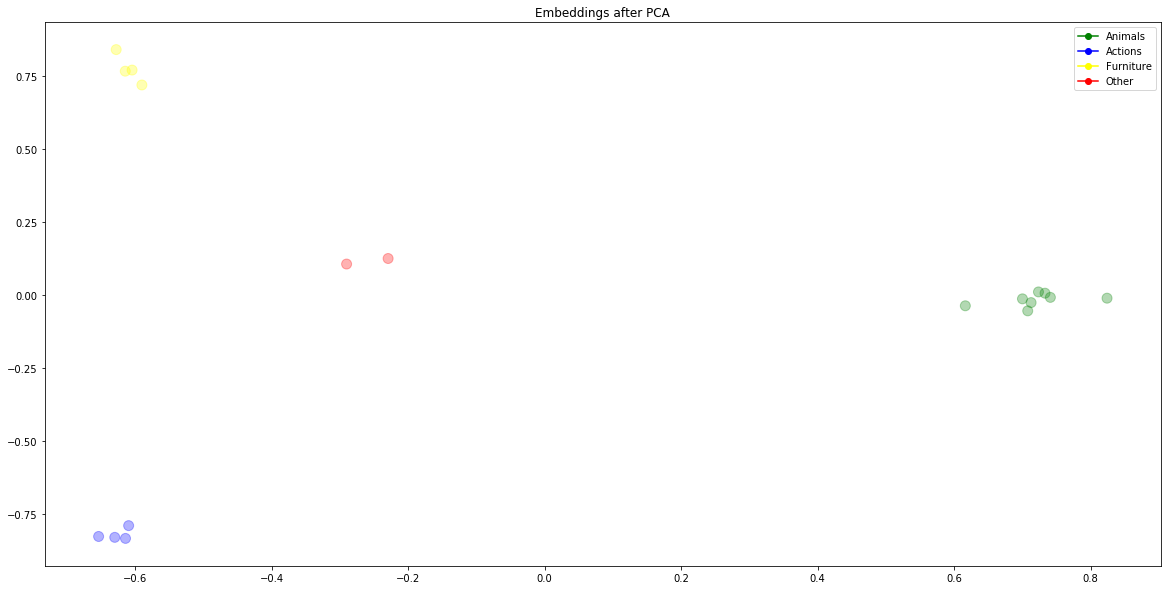

In [30]:
%matplotlib inline
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt


category_colors = {'animals' : 'green', 
                   'actions' : 'blue',
                   'furniture' : 'yellow'}

colors = []
for i in range(vocabulary_size):
    colors.append('red')
    
for word in tokenizer.word_index:
    index = tokenizer.word_index[word] -1
    if word in animals:
        colors[index] = category_colors['animals']
    elif word in actions:
        colors[index] = category_colors['actions']
    elif word in furniture:
        colors[index] = category_colors['furniture']
        
def plot_embeddings_after_pca(vectors):  
        """
        Perform PCA and plot the resulting 2 components on X and Y axis
        Args:
          embedding_weights - the set of vectors to 
        """
        pca = PCA(n_components=2)
        vectors_pca = pca.fit_transform(vectors)
        plt.figure(figsize=(20,10))
        
        # We do not draw the first element, which is the 'Out-of-Vocabulary' token
        plt.scatter(vectors_pca[1:,0], vectors_pca[1:,1], c=colors, s=100, alpha=0.3);
        plt.title('Embeddings after PCA')
        legend_elements = [
                    plt.Line2D([0], [0], marker='o', color=category_colors['animals'], label='Animals'),
                    plt.Line2D([0], [0], marker='o', color=category_colors['actions'], label='Actions'),
                    plt.Line2D([0], [0], marker='o', color=category_colors['furniture'], label='Furniture'),
                    plt.Line2D([0], [0], marker='o', color='red', label='Other'),
                  ]

        # Create the figure
        plt.legend(handles=legend_elements);

        
plot_embeddings_after_pca(model.get_layer('embedding_layer').get_weights()[0])






#### 练习
1. 试验嵌入词和上下文窗口大小，了解它们如何影响最终结果。
2. 尝试使用将两个向量结合起来的其他方法代替点积运算。查看 [keras.layers.merge](https://keras.io/layers/merge/) 包寻找灵感。这些因素如何影响嵌入质量？
3. 迭代和/或优化器的选择如何影响嵌入质量？尝试 [keras.optimizers](https://keras.io/optimizers/) 包提供的其他优化器。

### 代码练习——执行 CBoW

在上文中，我们试验了 *Skip-Gram* 版本的 Word2Vec。如前所述，还有另一种名为*连续词袋(CBoW)* 的变体。回想一下，词袋表征不考虑词序。CBoW 方法与之相似，但其生成分布式表征，与词袋生成的离散和稀疏表征形成对比。

在本部分中，您将执行 Word2Vec CBoW 方法。

#### CBoW 方法

![](images/CBOW.png)
CBoW 架构，由 Mikolov 等稍作修改

与 Skip-Grams 不同，CBoW 同时考虑目标词前后的所有词。在上图中，$w(t-1)$ 和 $w(t-2)$ 是出现在目标词左侧的上下文词的嵌入，$w(t+1)$ 和 $w(t+2)$ 是右侧的内容词。本例中，窗口大小是 2，总共有 4 个上下文词。一旦确定了上下文词，下一步是计算上下文词嵌入的 *平均值*。事实上，任何合并上下文词嵌入的运算都可行，例如 $sum$。在这里，词序丢失，这就是“词袋”名称的来源。然后，就是简单的为选择独热编码的上下文词（表征为 $w(t)$）附加 [softmax](https://en.wikipedia.org/wiki/Softmax_function) 激活。

下面的单元包含的代码，用于生成长度为window_size序列，以及上下文词的独热编码表征。

In [31]:
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.layers import Lambda
import keras.backend as K

window_size = 2

def make_cbow_data(sequences, window_size):
    """
    Prepare CBOW data - given a sequence of words, return the set of subsequences of window_size words on the left and the right
    along with the 1-hot encoded context word
    Args:
      sequences - set of sequences that encode sentences
      window_size - the amount of words to look to the left and right of the context word
    Returns:
      num_classes - number of words in vocabulary
      X - numpy array of window_size words to the left and right of the context word
      y - 1-hot encoding of the context word
    """
    X = []
    y = []
    num_classes = len(np.unique(np.hstack(sequences)))+1
    for this_sequence in sequences:
        for output_index, this_word in enumerate(this_sequence):
            this_input = []
            y.append(np_utils.to_categorical(this_word, num_classes))
            input_indices = [output_index - i for i in range(window_size,0,-1)]
            input_indices += [output_index + i for i in range(1, window_size+1)]
            for i in input_indices:
                this_input.append(this_sequence[i] if i >= 0 and i < len(this_sequence) else 0)
            X.append(this_input)
    return num_classes, np.array(X),np.array(y)
                
   
        
num_classes, cbow_X, cbow_y = make_cbow_data(sequences, window_size)
print("cbow_X shape: {}".format(cbow_X.shape))
print("cbow_y shape: {}".format(cbow_y.shape))

cbow_X shape: (768, 4)
cbow_y shape: (768, 19)


在这个单元中，填入执行该模型的代码。查看[此处](#hint6 \"使用 Keras 提供的 Embedding、Lambda 和 Dense 图层。对于平均值运算，使用可以访问 Keras 后端的 K 对象。\")获取提示。本手册的最后提供答案

完成练习的一些提示：
* 使用 Keras *Lambda* 图层(文档[此处](https://keras.io/layers/core/#lambda))来封装 mean_layer 代码中 K.mean 函数的使用
* 使用 *Softmax* 激活输出层

In [32]:
inputs = Input((window_size * 2,))

embedding_layer = Embedding(num_classes, EMBEDDING_SIZE, input_length=2*window_size, name='embedding_layer')
mean_layer = Lambda(lambda x: K.mean(x, axis=1))
output_layer = Dense(num_classes, activation='softmax')


output = embedding_layer(inputs)
output = mean_layer(output)
output = output_layer(output)

model = Model(inputs=[inputs], outputs=output)

optimizer = RMSprop(lr=0.1, rho=0.99)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)



您现在可以训练模型，并将 CBoW 生成的嵌入与 Skipgram 生成的上述嵌入进行比较。

In [33]:
train(cbow_X, cbow_y)

Epoch 100 - loss 0.8376762469609579
Epoch 200 - loss 0.8249201774597168
Epoch 300 - loss 0.8194901545842489
Epoch 400 - loss 0.8255734841028849
Epoch 500 - loss 0.8226005434989929
Epoch 600 - loss 0.8178193171819051
Epoch 700 - loss 0.8235245943069458
Epoch 800 - loss 0.8184442520141602
Epoch 900 - loss 0.8234336177508036
Epoch 1000 - loss 0.8203403155008951
Epoch 1100 - loss 0.820651650428772
Epoch 1200 - loss 0.8211220105489095
Epoch 1300 - loss 0.8220203518867493
Epoch 1400 - loss 0.8493712345759074
Epoch 1500 - loss 0.8936142524083456


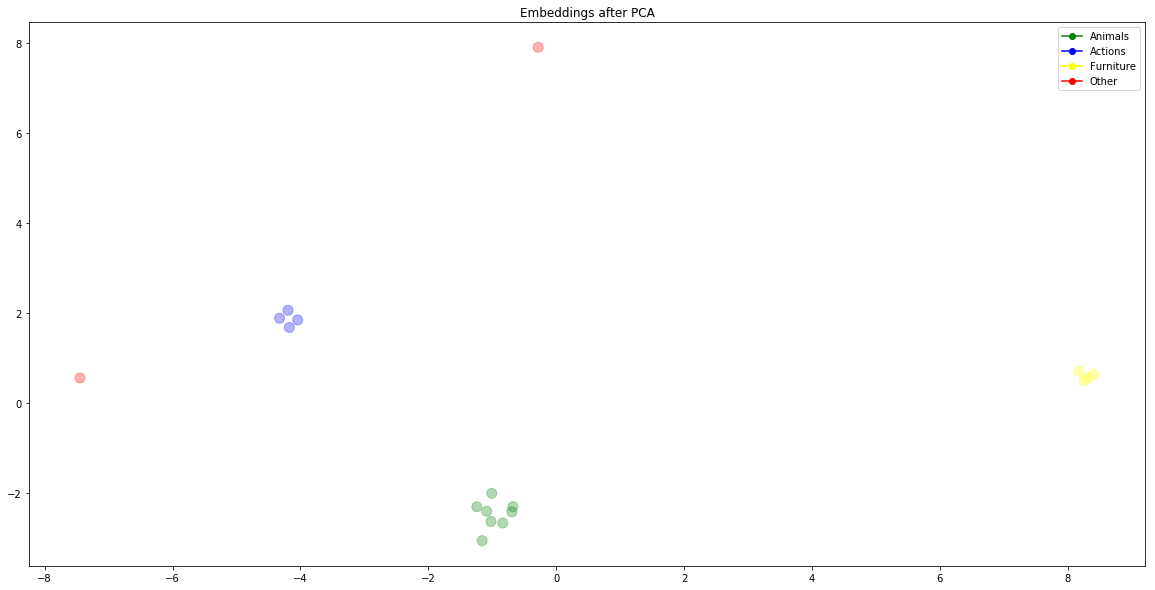

In [34]:
plot_embeddings_after_pca(model.get_layer('embedding_layer').get_weights()[0])

### 应用词嵌入

在下文中，我们将看到如何应用预训练的词嵌入。我们将使用由 Facebook AI 开发的 *FastText* 算法生成的嵌入。它与我们在上文看到的 Word2Vec 相似，提供 CBOW 和 Skip-Gram 两种变体，但以不同方式执行嵌入的实际“建构”，专为有复杂[形态](https://en.wikipedia.org/wiki/Morphology_(linguistics))的语言设计。Facebook 已在大型语料库上进行了嵌入训练（在本例中，利用来自维基百科原始数据的多语言数据），并提供这些数据[访问 Facebook Research GitHub 站点](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md)。此链接还包含了对描述 FastText 算法的论文的引用。

我们将重复我们在实验开始时所做的小试验，但这次我们使用 FastText 词嵌入。我们的分类器能够泛化吗？
模型下载位置
https://fasttext.cc/docs/en/pretrained-vectors.html


In [36]:
from gensim.models import KeyedVectors

# Load embeddings from the pre-trained file
fastText_embeddings = KeyedVectors.load_word2vec_format('d:/wiki.simple.vec')

In [37]:
def build_data_set(corpus):
    """
    Iterate over all sentences in the corpus and for each word, copy the embedding to the appropriate indices
    Args:
      corpus - list of individual sentences in the corpus
    Returns:
      X - Matrix of 1-hot encodings of the sentences
    """
    
    # Assume all sentences are of equal length - otherwise we'll need to truncate or pad
    words_in_sentence = len(corpus[0].split(' '))
    
    # Initialize 
    X = np.zeros((len(corpus), words_in_sentence * fastText_embeddings.vector_size))

    for sent_index in range(len(corpus)):
        words = corpus[sent_index].split(' ')
        for word_index in range(len(words)):
            start_index = fastText_embeddings.vector_size * word_index
            end_index = fastText_embeddings.vector_size * (word_index + 1)
            X[sent_index, start_index:end_index] = fastText_embeddings[words[word_index].lower()] 
    
    return X
            

# Train the model - animals are allowed on the mat, other objects are not
training_corpus = ['The cat sat on the mat', 'The dog sat on the mat', 'The goat sat on the mat', 'The elephant sat on the mat', 
          'The plane sat on the mat', 'The apple sat on the mat', 'The pen sat on the mat', 'The notebook sat on the mat']
allowed = np.array(
           [1,1,1,1,
            0,0,0,0])

X_train = build_data_set(training_corpus)
        
# Will the network be able to generalize?        
test_corpus = ['The keyboard sat on the mat', 'The bird sat on the mat']
X_test = build_data_set(test_corpus)



In [38]:
logistic_embeddings = LogisticRegression()
logistic_embeddings.fit(X_train, allowed)

y_test = [0,1]

print("Expected Results for (keyboard, bird):  {}".format(y_test))
print("Actual   Results for (keyboard, bird):  {}".format(logistic_embeddings.predict(X_test)))

Expected Results for (keyboard, bird):  [0, 1]
Actual   Results for (keyboard, bird):  [0 1]


### 总结

在本实验里，我们讨论了如何使用词汇嵌入将单个词表征用于 NLP 算法。我们讨论了影响词袋表征的多个问题，并了解到词嵌入如何解决这些问题。然后，我们使用一个小的语料库来训练我们自己的嵌入，最后使用预训练的一套嵌入来解决文本分类问题。

嵌入和分布式表征的概念非常广泛，您不会感到奇怪的是，存在多种为句子甚至整个文档计算嵌入的技术和算法。事实上，这是 NLP 研究中最活跃的领域之一。这些嵌入能够在一个领域中捕获语义相似度，因此适合作为其他下游 NLP 任务的输入。

最后，这里有一些最佳实践可用于训练您自己的嵌入：
* 使用领域特定的大型文本语料库。使用通用语料库（如维基百科）可能会影响您的特定于应用的模型的准确性和性能。如果您没有大量领域特定的文本，那么通过在预训练好的词嵌入上进行“迁移学习”可能会有所帮助。
* 计划一个长时间的训练过程。强烈推荐使用一个或多个 GPU。
* 您需要微调嵌入维度和上下文窗口大小。您在这里所做的选择将直接影响您的模型的准确性和所需的训练时间。

#### [CBoW 代码答案](task1_Answers.ipynb)

<a href="https://www.nvidia.com/dli/"> <img src="https://developer.download.nvidia.com/training/images/DLI%20Header.png" alt="标题" style="width: 400px;"/> </a>